Using device: cuda
inout_seq length: 44
Epoch 0, Loss: 0.051411811262369156
Epoch 20, Loss: 0.0036095338873565197
Epoch 40, Loss: 0.005829045549035072
Epoch 60, Loss: 0.007970856502652168
Epoch 80, Loss: 0.00949865486472845
Epoch 100, Loss: 0.014887019991874695
Epoch 120, Loss: 0.00991714745759964
Epoch 140, Loss: 0.009551486931741238
Epoch 160, Loss: 0.015618042089045048
Epoch 180, Loss: 0.009802647866308689
Epoch 200, Loss: 0.010945851914584637
Epoch 220, Loss: 0.007068310398608446
Epoch 240, Loss: 8.976871322374791e-05
Epoch 260, Loss: 7.46240584703628e-06
Epoch 280, Loss: 0.00019722686556633562
Epoch 300, Loss: 0.0011055885115638375
Epoch 320, Loss: 0.000636465207207948
Epoch 340, Loss: 7.273583469213918e-05
Epoch 360, Loss: 0.001967131160199642
Epoch 380, Loss: 0.0009233579621650279
Epoch 400, Loss: 0.00016158740618266165
Epoch 420, Loss: 0.00026351891574449837
Epoch 440, Loss: 9.611710993340239e-06
Epoch 460, Loss: 0.00018056025146506727
Epoch 480, Loss: 0.0003015031688846648
pre

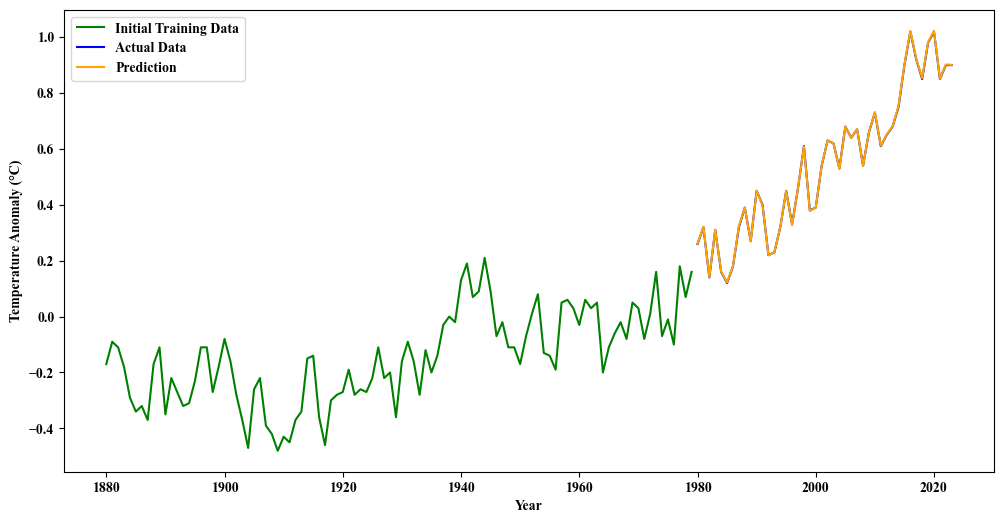

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 设置字体样式为Times New Roman并加粗
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

# 检查CUDA是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 加载数据并进行预处理
df = pd.read_csv('data/global_temps.csv')
for column in df.columns:
    if df[column].isnull().any():
        df[column] = df[column].interpolate(method='linear')
if df.iloc[0].isnull().any():
    mean_val = df.iloc[1:3].mean()
    df.iloc[0] = df.iloc[0].fillna(mean_val)

# 将年份转换为日期格式并设置为索引
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)
ts = df['J-D']

# 归一化数据
scaler = MinMaxScaler(feature_range=(-1, 1))
ts_scaled = scaler.fit_transform(ts.values.reshape(-1, 1))

# 创建数据集以适应CNN-LSTM
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i + tw]
        train_label = input_data[i + tw]
        inout_seq.append((train_seq, train_label))
    return inout_seq

# 设置时间步长
time_step = 100
inout_seq = create_inout_sequences(ts_scaled, time_step)

# 打印数据集形状
print(f"inout_seq length: {len(inout_seq)}")

# 定义 CNN-LSTM 模型
class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=32, hidden_size=50, num_layers=1, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # 调整为 [batch_size, sequence_length, channels]
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

# 初始化模型、损失函数和优化器
model = CNNLSTM().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
epochs = 500
for epoch in range(epochs):
    model.train()
    for seq, labels in inout_seq:
        seq = torch.FloatTensor(seq).unsqueeze(0).permute(0, 2, 1).to(device)
        labels = torch.FloatTensor(labels).unsqueeze(0).to(device)

        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {single_loss.item()}')

# 进行预测
model.eval()
predict = []
with torch.no_grad():
    for seq, _ in inout_seq:
        seq = torch.FloatTensor(seq).unsqueeze(0).permute(0, 2, 1).to(device)
        predict.append(model(seq).item())

# 反归一化数据
predict = scaler.inverse_transform(np.array(predict).reshape(-1, 1))

# 打印预测结果形状
print(f"predict shape: {predict.shape}")

# 确认索引的长度和预测结果的长度一致
predict_index = ts.index[time_step:time_step + len(predict)]

print(f"predict_index length: {len(predict_index)}")

# 评估指标
mse = mean_squared_error(ts.values[time_step:], predict)
mae = mean_absolute_error(ts.values[time_step:], predict)
r2 = r2_score(ts.values[time_step:], predict)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# 绘制结果
plt.figure(figsize=(12, 6))
plt.plot(ts.index[:time_step], ts.values[:time_step], label='Initial Training Data', color='green')
plt.plot(ts.index[time_step:], ts.values[time_step:], label='Actual Data', color='blue')
plt.plot(predict_index, predict, label='Prediction', color='orange')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
#plt.title('Actual Data and Predictions with CNN-LSTM')
plt.legend()
plt.savefig('Actual Data and Predictions with CNN-LSTM.png', dpi=800)
plt.show()

Using device: cuda
Epoch 0, Loss: 0.027369454503059387
Epoch 20, Loss: 0.0036914541851729155
Epoch 40, Loss: 0.005275400821119547
Epoch 60, Loss: 0.0092768594622612
Epoch 80, Loss: 0.004391427617520094
Epoch 100, Loss: 0.0037842532619833946
Epoch 120, Loss: 0.0038869024720042944
Epoch 140, Loss: 0.0034116851165890694
Epoch 160, Loss: 0.01243050117045641
Epoch 180, Loss: 0.0054228040389716625
Epoch 200, Loss: 0.001455227960832417
Epoch 220, Loss: 0.003914599306881428
Epoch 240, Loss: 0.0003409467753954232
Epoch 260, Loss: 0.004609479568898678
Epoch 280, Loss: 0.0019789498765021563
Epoch 300, Loss: 0.0018521164311096072
Epoch 320, Loss: 0.0003898482536897063
Epoch 340, Loss: 0.0025495493318885565
Epoch 360, Loss: 0.0007481077336706221
Epoch 380, Loss: 0.014795600436627865
Epoch 400, Loss: 0.0007585549028590322
Epoch 420, Loss: 0.0020915050990879536
Epoch 440, Loss: 0.0001780541060725227
Epoch 460, Loss: 0.0003201813669875264
Epoch 480, Loss: 0.0009808923350647092


C:\Users\13122\AppData\Local\Temp\ipykernel_10400\2957837431.py:128: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_dates = pd.date_range(start=ts.index[-1] + pd.DateOffset(years=1), periods=100, freq='Y')


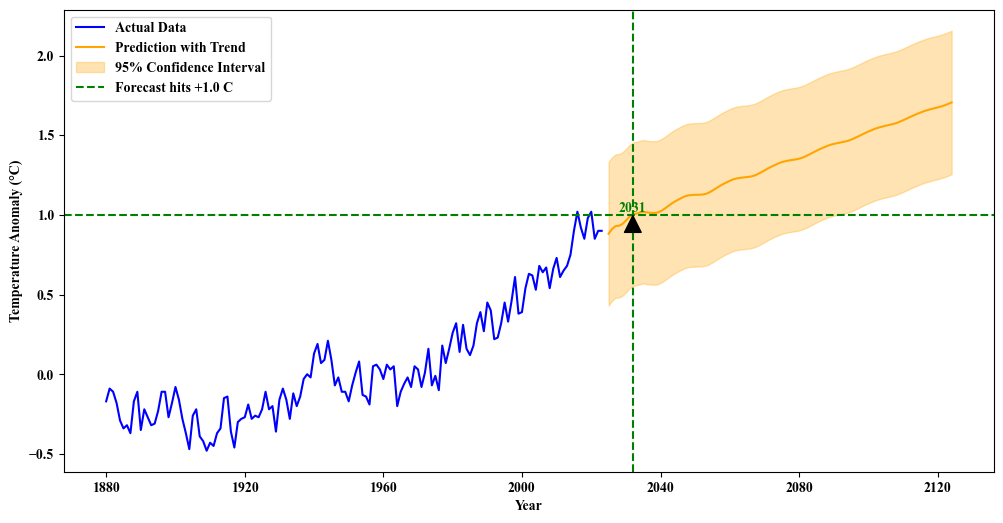

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# 设置字体样式为Times New Roman并加粗
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

# 设置随机种子以确保可复现性
SEED = 412
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 检查CUDA是否可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 加载数据并进行预处理
df = pd.read_csv('data/global_temps.csv')
for column in df.columns:
    if df[column].isnull().any():
        df[column] = df[column].interpolate(method='linear')
if df.iloc[0].isnull().any():
    mean_val = df.iloc[1:3].mean()
    df.iloc[0] = df.iloc[0].fillna(mean_val)

# 将年份转换为日期格式并设置为索引
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)
ts = df['J-D']

# 归一化数据
scaler = MinMaxScaler(feature_range=(-1, 1))
ts_scaled = scaler.fit_transform(ts.values.reshape(-1, 1))

# 创建数据集以适应CNN-LSTM
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i + tw]
        train_label = input_data[i + tw]
        inout_seq.append((train_seq, train_label))
    return inout_seq

# 设置时间步长
time_step = 100
inout_seq = create_inout_sequences(ts_scaled, time_step)

# 定义 CNN-LSTM 模型
class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=32, hidden_size=50, num_layers=1, batch_first=True)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # 调整为 [batch_size, sequence_length, channels]
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

# 初始化模型、损失函数和优化器
model = CNNLSTM().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
epochs = 500
for epoch in range(epochs):
    model.train()
    for seq, labels in inout_seq:
        seq = torch.FloatTensor(seq).unsqueeze(0).permute(0, 2, 1).to(device)
        labels = torch.FloatTensor(labels).unsqueeze(0).to(device)

        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {single_loss.item()}')

# 预测未来100年
model.eval()
predict = []
last_seq = torch.FloatTensor(ts_scaled[-time_step:]).unsqueeze(0).permute(0, 2, 1).to(device)
with torch.no_grad():
    for i in range(100):
        pred = model(last_seq).item()
        predict.append(pred)
        # 将预测结果添加到序列末尾，并删除第一个元素
        last_seq = torch.cat((last_seq[:, :, 1:], torch.FloatTensor([[[pred]]]).to(device)), dim=2)

# 反归一化数据
predict = scaler.inverse_transform(np.array(predict).reshape(-1, 1))

# 拟合历史数据的趋势
years = np.arange(len(ts))
trend_poly = np.polyfit(years, ts.values, deg=1)
trend = np.poly1d(trend_poly)

# 生成未来100年的趋势
future_years = np.arange(len(ts), len(ts) + 100)
trend_values = trend(future_years)
predict_with_trend = predict.flatten() + trend_values - trend(len(ts))  # 调整预测结果，使其平滑过渡

# 计算置信区间
pred_std = np.std(predict_with_trend)
conf_interval = 1.96 * pred_std  # 95%置信区间

# 创建未来100年的索引
future_dates = pd.date_range(start=ts.index[-1] + pd.DateOffset(years=1), periods=100, freq='Y')

# 找到预测结果中首次达到基线的年份
baseline = 1.0
crossing_index = np.argmax(predict_with_trend >= baseline)
crossing_year = future_dates[crossing_index]

# 绘制结果
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts.values, label='Actual Data', color='blue')
plt.plot(future_dates, predict_with_trend, label='Prediction with Trend', color='orange')
plt.fill_between(future_dates, predict_with_trend - conf_interval, predict_with_trend + conf_interval, color='orange', alpha=0.3, label='95% Confidence Interval')

# 添加基线
plt.axhline(y=baseline, color='green', linestyle='--')
plt.axvline(x=crossing_year, color='green', linestyle='--', label='Forecast hits +1.0 C')

# 添加注释
plt.text(crossing_year, baseline, str(crossing_year.year), color='green', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.annotate('', xy=(crossing_year, baseline), xytext=(crossing_year, baseline-0.1), arrowprops=dict(facecolor='black', shrink=0.05))

plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.savefig('cnnlstmpredicate.jpg', dpi=800)
plt.show()
